# MNIST example tutorial

# import some libraries

torch is pytorch. There are also several other functions. </br>
matplotlib is for plotting. </br>
pickle is a way to read and write data. It output things in .pkl format.  </br>
train_test_split is a function to split training and testing data. It comes from the module sklean </br>

%matplotlib inline is necessary to plot things in the notebook itself.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import os
import pickle

%matplotlib inline

from sklearn.model_selection import train_test_split

#limit gpu memory usage
# torch.cuda.set_per_process_memory_fraction(0.23, device=0)

#change to "cuda" to use GPU
device = 'cpu'

Now, we read the MNIST data. Read more about this dataset here: [https://en.wikipedia.org/wiki/MNIST_database](https://en.wikipedia.org/wiki/MNIST_database)

x is the input data and y is the ground truth. By the way, 3Blue1Brown also uses the same dataset. See here: [https://www.youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi](https://www.youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi)

We will first download the data from: save it in the datasets folder, and then proceeds with the code..

In [2]:
# Import necessary libraries
import requests
import os

# Define the URL of the .pkl file
url = "https://github.com/mnielsen/neural-networks-and-deep-learning/raw/master/data/mnist.pkl.gz"

# Define the path where the file will be saved
save_path = "datasets/mnist.pkl.gz"

# Create the directory if it doesn't exist
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Download the file
response = requests.get(url)
with open(save_path, 'wb') as file:
    file.write(response.content)

print(f"Downloaded and saved MNIST dataset to {save_path}")

# Optional: Extract the .pkl file if necessary
import gzip
import shutil

with gzip.open(save_path, 'rb') as f_in:
    with open(save_path[:-3], 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

print(f"Extracted MNIST dataset to {save_path[:-3]}")


Downloaded and saved MNIST dataset to datasets/mnist.pkl.gz
Extracted MNIST dataset to datasets/mnist.pkl


In [8]:
# Read the data with explicit encoding
with open("datasets/mnist.pkl", 'rb') as f:
    dset = pickle.load(f, encoding='latin1')

# Unpack the first element of dset to get x and y
(x, y), *_ = dset

# Verify the shapes or types of x and y
print(type(x), type(y))
print(x.shape, y.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(50000, 784) (50000,)


Here, we see some characteristics of the data. 

In [9]:
N=x.shape[0]                   #total number of samples
sz=int(np.sqrt(x.shape[1]))    #size of image

print(f"total samples: \t\t{N}")
print(f"Size of each image is {sz}X{sz}")

total samples: 		50000
Size of each image is 28X28


Now, you can plot the images to see the numbers. Always a good idea to visualize the data. Your eyes are the best computer vision tool out there. 

Task: try plotting more numbers (by changing the argument of range()). See if you recognize these numbers.

5


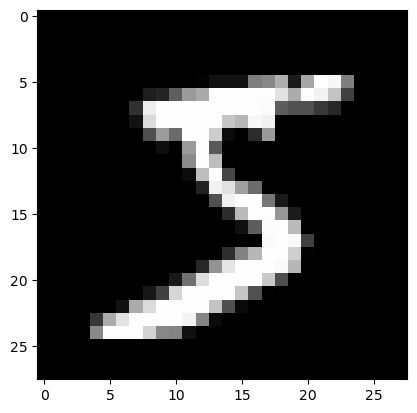

0


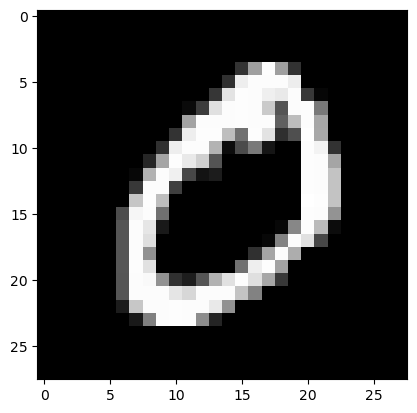

4


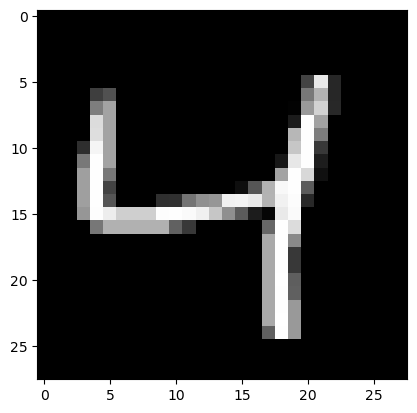

1


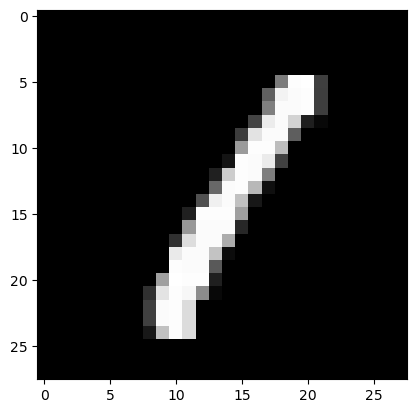

9


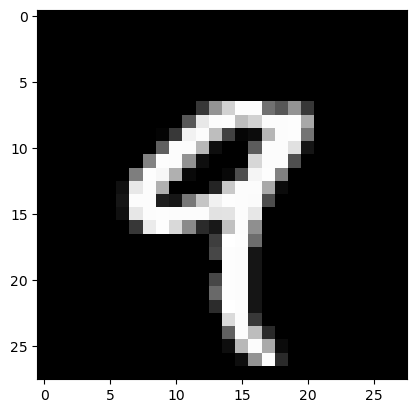

2


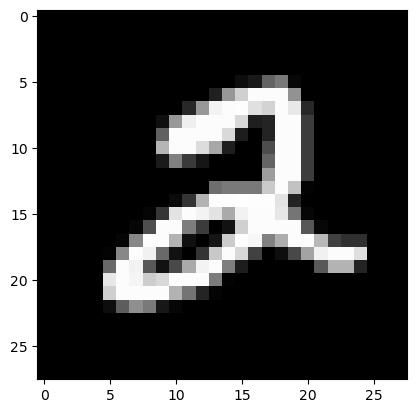

1


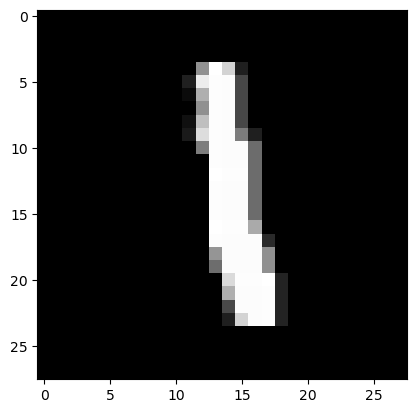

3


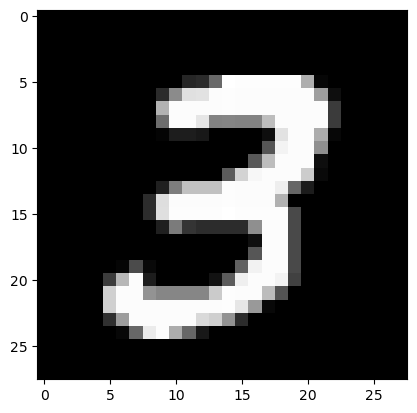

1


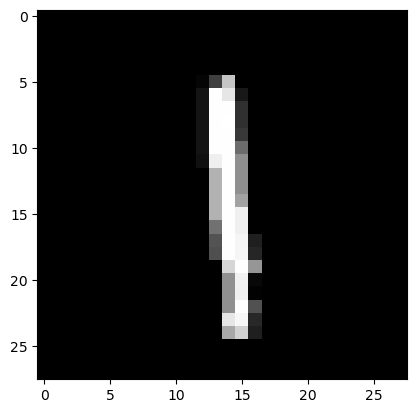

4


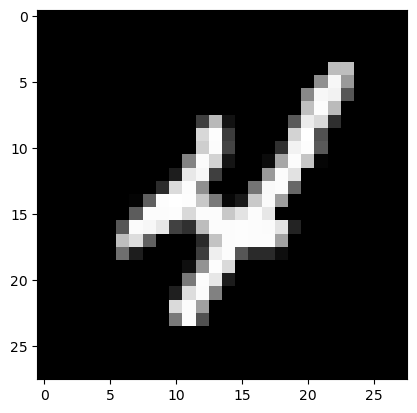

In [10]:
#let's plot some images
for img in range(10):
    print(y[img])
    img = x[img,:].reshape(sz,sz) 
    plt.imshow(img,cmap='gray')
    plt.show() 

Now, we split the data into training and testing. Here, we choose 10% of the total data as testing data, i.e., trianing data is 90% of all the images. 

Task: change this numbers (test_size) and see what happend. You will have to run all the code cells below once you have changed test_size

In [11]:
#split the data in train and test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)

N_train = x_train.shape[0]

print(N_train)

45000


# define the Neural Network class

Here, you create a neural network. Read on the internet what these layers and numbers mean. Please do go online and learn about this. It is the most important part of this code.

In [12]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.layer1 = nn.Linear(input_dim, 20)
        self.layer2 = nn.Linear(20, 50)
        self.layer3 = nn.Linear(50, output_dim)
        
    def forward(self, x):        
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)
    

Now, you will initialize the neural network. Do not worry about "device" for now. This code was written in such a way that it could be run on GPU as well. But for now, we will only use CPU. 

In [13]:
#instantiate the Neural Network
model = MLP(sz*sz,10).to(device)
print(model)

MLP(
  (layer1): Linear(in_features=784, out_features=20, bias=True)
  (layer2): Linear(in_features=20, out_features=50, bias=True)
  (layer3): Linear(in_features=50, out_features=10, bias=True)
)


# Choose an optimizer. 

Read about available optimizers here: [https://pytorch.org/docs/stable/optim.html](https://pytorch.org/docs/stable/optim.html)

Read this too: [https://machinelearningknowledge.ai/pytorch-optimizers-complete-guide-for-beginner/](https://machinelearningknowledge.ai/pytorch-optimizers-complete-guide-for-beginner/)

Lastly, also here: [https://analyticsindiamag.com/ultimate-guide-to-pytorch-optimizers/](https://analyticsindiamag.com/ultimate-guide-to-pytorch-optimizers/): you must google the names of the optimizer algorithms you find on this page. 

In [14]:

#instantiate the optimizer
optimizer = optim.Adam(model.parameters())
print(optimizer) # prints the different input features of the optimizer. These are the things you can change. 

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


# define the criterion for the computation of the loss

Read about loss criterion here: [https://pytorch.org/docs/stable/nn.html#loss-functions](https://pytorch.org/docs/stable/nn.html#loss-functions)

Some details here: [https://neptune.ai/blog/pytorch-loss-functions](https://neptune.ai/blog/pytorch-loss-functions)

Basically, this is where you will choose how to estimate the error between the prediction and ground truth while training the neural network

In [15]:
criterion = nn.CrossEntropyLoss()
batch_size = 500

# Training the neural network

This is where you train the neural network.

In [16]:
epochs = 100 #total number of iterations

loss_list = []

for epoch in range(epochs):
    sel = np.random.choice(range(N_train),batch_size,replace=False)
    #read data from dataset
    x = torch.tensor(x_train[sel],dtype=torch.float32,device=device)
    y = torch.tensor(y_train[sel],dtype=torch.long,device=device)

    #evaluate the NN
    pred = model(x)

    #compute the loss, backward and gradient descent
    loss = criterion(pred,y)
    loss.backward()
    optimizer.step()

    #zero the gradients
    optimizer.zero_grad() 

    #append loss to list
    loss_list.append(loss.detach().to('cpu'))
        
    #print current statistics
    print(f"epoch={epoch}/{epochs}; loss={loss}")

epoch=0/100; loss=2.303636074066162
epoch=1/100; loss=2.288334846496582
epoch=2/100; loss=2.2804031372070312
epoch=3/100; loss=2.271699905395508
epoch=4/100; loss=2.2600762844085693
epoch=5/100; loss=2.2569172382354736
epoch=6/100; loss=2.240187168121338
epoch=7/100; loss=2.2182533740997314
epoch=8/100; loss=2.213890314102173
epoch=9/100; loss=2.20371675491333
epoch=10/100; loss=2.1712169647216797
epoch=11/100; loss=2.1730446815490723
epoch=12/100; loss=2.1424200534820557
epoch=13/100; loss=2.1291069984436035
epoch=14/100; loss=2.104978561401367
epoch=15/100; loss=2.0906848907470703
epoch=16/100; loss=2.0654451847076416
epoch=17/100; loss=2.04988694190979
epoch=18/100; loss=2.0413107872009277
epoch=19/100; loss=2.0109612941741943
epoch=20/100; loss=1.9676964282989502
epoch=21/100; loss=1.9640958309173584
epoch=22/100; loss=1.9333120584487915
epoch=23/100; loss=1.9194090366363525
epoch=24/100; loss=1.892844319343567
epoch=25/100; loss=1.843860149383545
epoch=26/100; loss=1.8272154331207

Next, we will plot the loss function. See that the loss function decreases sharply but then converges to some constant value.

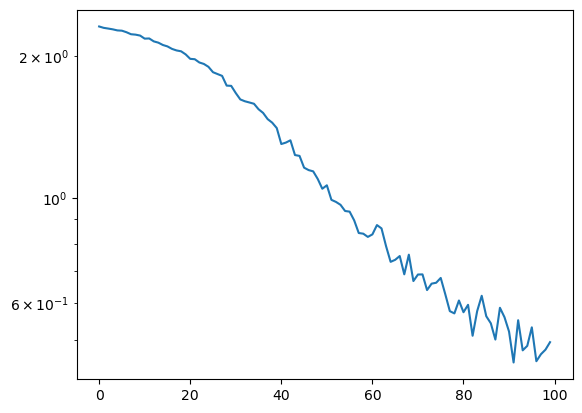

In [17]:
plt.plot(loss_list)
plt.yscale('log')
plt.show()

This is a way to compute accuracy of the model. Below is a function to compute accuracy.

In [18]:
def compute_accuracy(pred, y):
    #select the top probability
    top_pred = pred.argmax(1, keepdim = True)[:,0]
    #compute number of correct predictions
    correct = (top_pred==y).sum()
    #compute accuracy
    acc = correct.float() / y.shape[0]
    return acc

Let us print some images to test

6


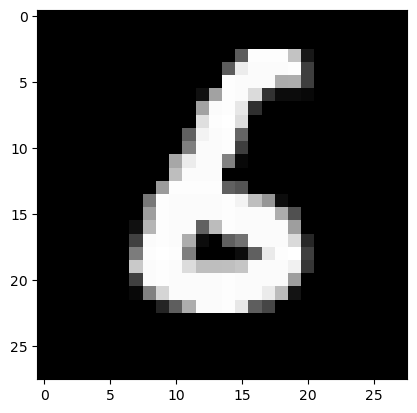

1


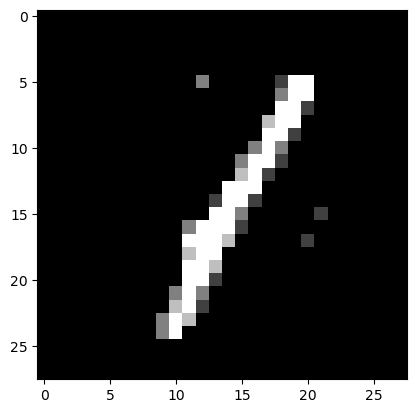

5


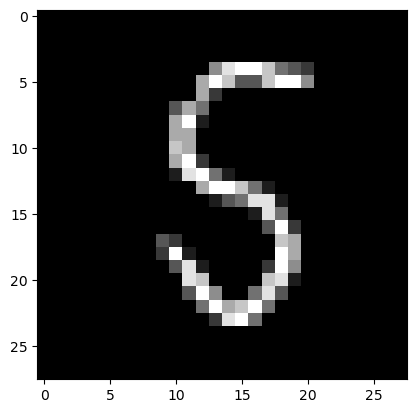

3


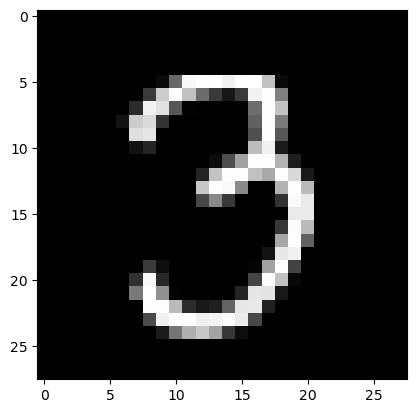

9


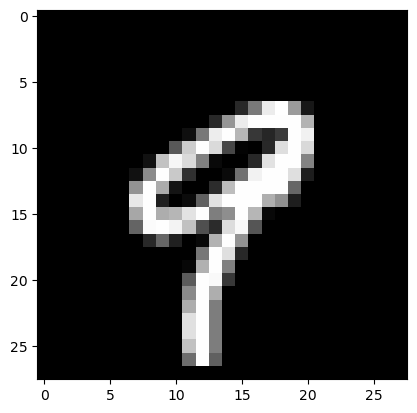

In [19]:
#let's plot some images
for img in range(5):
    print(y_test[img])
    img = x_test[img,:].reshape(sz,sz) 
    plt.imshow(img,cmap='gray')
    plt.show() 

Here, we will use the testing data (see x_test) and use neural network to make predictions (pred), and then test it against the ground truth (y_test)

In [20]:
with torch.no_grad():
    x = torch.tensor(x_test,dtype=torch.float32,device=device)
    y = torch.tensor(y_test,dtype=torch.long,device=device)
    
    pred = model(x)
    
    acc = compute_accuracy(pred,y)

    print(f"test accuracy: {acc}")

test accuracy: 0.8604000210762024


So, the accuracy is the number above. Not bad. Eh?

In [21]:
top_pred = pred.argmax(1, keepdim = True)[:,0]
print(top_pred)
print(y_test)
for j in range(len(y_test)):
    print("number is %g and prediction is %g" % (y_test[j], top_pred[j].float()))

tensor([6, 1, 6,  ..., 3, 5, 6])
[6 1 5 ... 3 5 6]
number is 6 and prediction is 6
number is 1 and prediction is 1
number is 5 and prediction is 6
number is 3 and prediction is 3
number is 9 and prediction is 9
number is 7 and prediction is 7
number is 9 and prediction is 7
number is 7 and prediction is 7
number is 4 and prediction is 4
number is 0 and prediction is 0
number is 1 and prediction is 1
number is 1 and prediction is 1
number is 4 and prediction is 4
number is 3 and prediction is 3
number is 4 and prediction is 4
number is 0 and prediction is 0
number is 4 and prediction is 4
number is 8 and prediction is 8
number is 4 and prediction is 4
number is 2 and prediction is 2
number is 5 and prediction is 5
number is 0 and prediction is 0
number is 6 and prediction is 6
number is 7 and prediction is 7
number is 4 and prediction is 4
number is 7 and prediction is 7
number is 6 and prediction is 6
number is 7 and prediction is 1
number is 2 and prediction is 2
number is 6 and predi